In [1]:
# Ploting packages
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow.keras

from datetime import datetime, timedelta

# The deep learning class
from deep_model import DeepModelTS 
# Reading the configuration file
import yaml
# Directory managment 
import os

Using TensorFlow backend.


In [2]:
# Reading the hyper parameters for the pipeline
with open(f'{os.getcwd()}\\conf.yml') as file:
    conf = yaml.load(file, Loader=yaml.FullLoader)


In [3]:
# lire les données 
d = pd.read_csv('C:/Users/OUMAIMA/Desktop/deep-learning-ts-master/input/DAYTON_hourly.csv')
d['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in d['Datetime']]
d.tail()


,Datetime,DAYTON_MW
121270,2018-01-01 20:00:00,2732.0
121271,2018-01-01 21:00:00,2724.0
121272,2018-01-01 22:00:00,2664.0
121273,2018-01-01 23:00:00,2614.0
121274,2018-01-02 00:00:00,2552.0


In [4]:
# enlever les données dupliquer
d = d.groupby('Datetime', as_index=False)['DAYTON_MW'].mean()
d.head()

,Datetime,DAYTON_MW
0,2004-10-01 01:00:00,1621.0
1,2004-10-01 02:00:00,1536.0
2,2004-10-01 03:00:00,1500.0
3,2004-10-01 04:00:00,1434.0
4,2004-10-01 05:00:00,1489.0


In [5]:
# Sort les données
d.sort_values('Datetime', inplace=True)
d.tail()

,Datetime,DAYTON_MW
121266,2018-08-02 20:00:00,2554.0
121267,2018-08-02 21:00:00,2481.0
121268,2018-08-02 22:00:00,2405.0
121269,2018-08-02 23:00:00,2250.0
121270,2018-08-03 00:00:00,2042.0


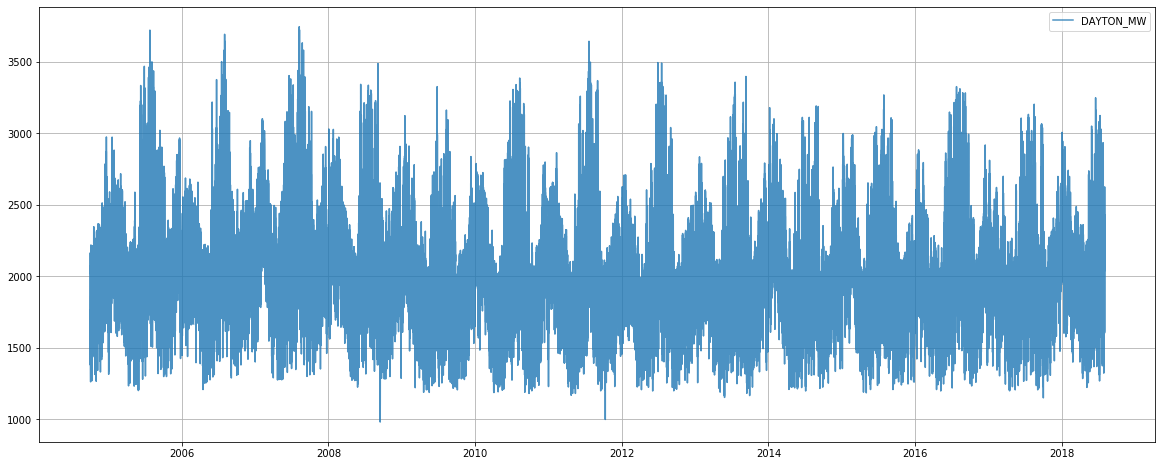

In [6]:
 plt.figure(figsize=(20, 8))
for dtype in ['DAYTON_MW']:
        plt.plot(
            'Datetime',
            dtype,
            data=d,
            label=dtype,
            alpha=0.8
        )
plt.legend()
plt.grid()
plt.show()

In [33]:
# Initiation de la classe
deep_learner = DeepModelTS(
    data=d, 
    Y_var='DAYTON_MW',
    lag=conf.get('lag'),#24
    LSTM_layer_depth=conf.get('LSTM_layer_depth'),#64
    epochs=conf.get('epochs'),#10
    train_test_split=conf.get('train_test_split') # The share of data that will be used for validation
)
#print(deep_learner.train_test_split)

In [34]:
# application du modéle
model = deep_learner.LSTModel()

Epoch 1/10
427/427 [==============================] - 39s 81ms/step - loss: 1025087.8750 - val_loss: 181379.4688
Epoch 2/10
427/427 [==============================] - 32s 75ms/step - loss: 114810.3516 - val_loss: 89516.1484
Epoch 3/10
427/427 [==============================] - 32s 74ms/step - loss: 73084.4141 - val_loss: 66683.1562
Epoch 4/10
427/427 [==============================] - 33s 77ms/step - loss: 70422.1875 - val_loss: 51390.2539
Epoch 5/10
427/427 [==============================] - 32s 75ms/step - loss: 41463.8281 - val_loss: 34101.6133
Epoch 6/10
427/427 [==============================] - 32s 75ms/step - loss: 29794.4902 - val_loss: 23759.5664
Epoch 7/10
427/427 [==============================] - 32s 74ms/step - loss: 22906.4277 - val_loss: 18655.0254
Epoch 8/10
427/427 [==============================] - 33s 78ms/step - loss: 19658.4102 - val_loss: 16352.9668
Epoch 9/10
427/427 [==============================] - 31s 74ms/step - loss: 18041.4473 - val_loss: 15261.4082
Epoch 

        index            Datetime  DAYTON_MW   prediction
0      109146 2017-03-15 19:00:00     2410.0  2432.438232
1      109147 2017-03-15 20:00:00     2422.0  2427.929932
2      109148 2017-03-15 21:00:00     2490.0  2464.904785
3      109149 2017-03-15 22:00:00     2415.0  2502.031006
4      109150 2017-03-15 23:00:00     2304.0  2460.619385
...       ...                 ...        ...          ...
12120  121266 2018-08-02 20:00:00     2554.0  2507.006592
12121  121267 2018-08-02 21:00:00     2481.0  2326.115967
12122  121268 2018-08-02 22:00:00     2405.0  2300.592285
12123  121269 2018-08-02 23:00:00     2250.0  2292.562256
12124  121270 2018-08-03 00:00:00     2042.0  2090.158203

[12125 rows x 4 columns]


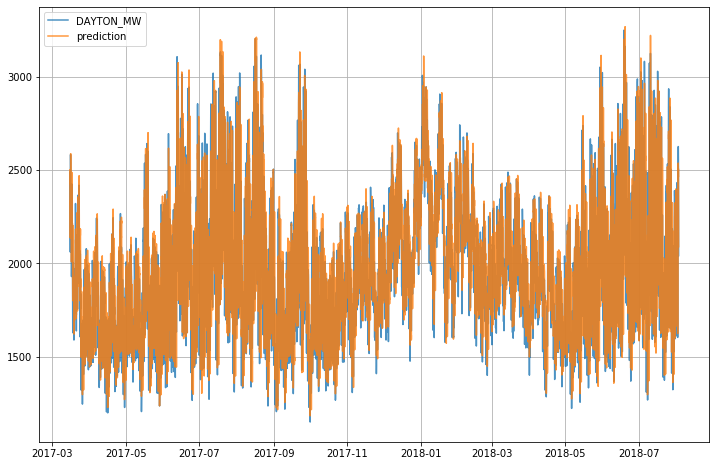

In [35]:
# faire la prédiction sur l'ensemble de validation
#Applicable uniquement si train_test_split dans the conf.yml > 0
yhat = deep_learner.predict()

if len(yhat) > 0:

    # construire le dataframe de prévision
    fc = d.tail(len(yhat)).copy()
    fc.reset_index(inplace=True)
    fc['prediction'] = yhat
    print(fc)
    # creer le plot
    plt.figure(figsize=(12, 8))
    for dtype in ['DAYTON_MW', 'prediction']:
        plt.plot(
            'Datetime',
            dtype,
            data=fc,
            label=dtype,
            alpha=0.8
        )
    plt.legend()
    plt.grid()
    plt.show()   
    

In [36]:
MAPE = tf.keras.metrics.mean_absolute_percentage_error(fc['DAYTON_MW'],fc['prediction'])
print('Lerreur moyenne absolue en pourcentage pour les prévisions est {:.2f}%'.format(MAPE))

Lerreur moyenne absolue en pourcentage pour les prévisions est 4.71%


In [37]:
# Prévision n étapes en avant  

# Création du modèle à l'aide de données complètes et prévision de n étapes en avant
deep_learner = DeepModelTS(
    data=d, 
    Y_var='DAYTON_MW',
    lag=24,
    LSTM_layer_depth=64,
    epochs=10,
    train_test_split=0 
)

In [38]:
# adapter le modéle
deep_learner.LSTModel()

Epoch 1/10
474/474 [==============================] - 37s 71ms/step - loss: 584329.9375
Epoch 2/10
474/474 [==============================] - 33s 70ms/step - loss: 23462.4902
Epoch 3/10
474/474 [==============================] - 34s 72ms/step - loss: 18619.7148
Epoch 4/10
474/474 [==============================] - 34s 73ms/step - loss: 24831.8145
Epoch 5/10
474/474 [==============================] - 33s 71ms/step - loss: 14809.8896
Epoch 6/10
474/474 [==============================] - 34s 71ms/step - loss: 675190.1250
Epoch 7/10
474/474 [==============================] - 34s 72ms/step - loss: 128650.5000
Epoch 8/10
474/474 [==============================] - 35s 73ms/step - loss: 101142.3281
Epoch 9/10
474/474 [==============================] - 34s 72ms/step - loss: 48153.5742
Epoch 10/10
474/474 [==============================] - 34s 72ms/step - loss: 35401.2148


In [42]:
# Prévision n étapes en avant  
n_ahead = 15720
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]


In [40]:
# construire le dataframe de prévision
fc1 = d.tail(90000).copy() 
fc1['type'] = 'original'

last_date = max(fc1['Datetime'])
hat_frame = pd.DataFrame({
    'Datetime': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'DAYTON_MW': yhat,
    'type': 'forecast'
})

fc = fc1.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
fc.tail(200)

,Datetime,DAYTON_MW,type
1520,2018-08-24 17:00:00,1966.889771,forecast
1521,2018-08-24 18:00:00,1965.577026,forecast
1522,2018-08-24 19:00:00,1965.357910,forecast
1523,2018-08-24 20:00:00,1964.516479,forecast
1524,2018-08-24 21:00:00,1963.787964,forecast
...,...,...,...
1715,2018-09-01 20:00:00,1841.568970,forecast
1716,2018-09-01 21:00:00,1840.822021,forecast
1717,2018-09-01 22:00:00,1840.277344,forecast
1718,2018-09-01 23:00:00,1839.606812,forecast


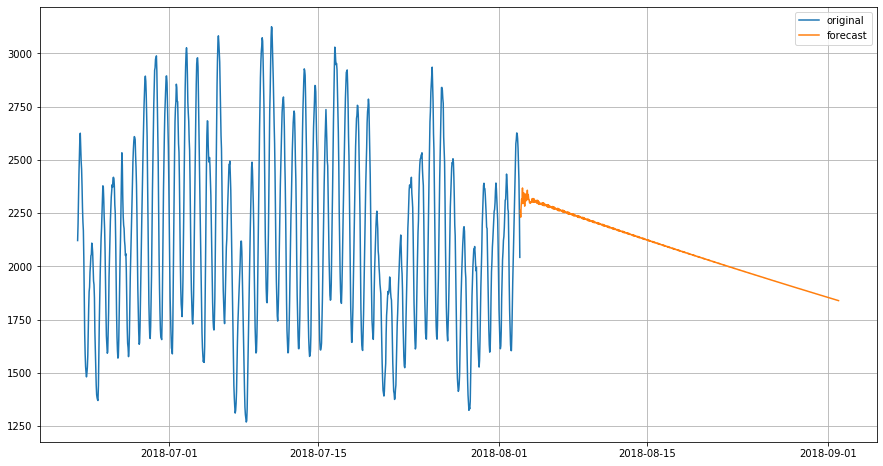

In [41]:
# Plot du prévision 
plt.figure(figsize=(15, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'Datetime', 
        'DAYTON_MW', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()
plt.show()    